# Primera parte: Introducción a las redes neuronales con Keras

En esta primera parte, vamos a utilizar una red neuronal para clasificar imágenes de prendas de ropa. Para ello, utilizaremos Keras con TensorFlow.

El dataset a utilizar es Fashion MNIST, un problema sencillo con imágenes pequeñas de ropa, pero más interesante que el dataset de MNIST. Puedes consultar más información sobre el dataset en [este enlace](https://github.com/zalandoresearch/fashion-mnist).

El código utilizado para contestar tiene que quedar claramente reflejado en el Notebook. Puedes crear nuevas cells si así lo deseas para estructurar tu código y sus salidas. A la hora de entregar el notebook, **asegúrate de que los resultados de ejecutar tu código han quedado guardados** (por ejemplo, a la hora de entrenar una red neuronal tiene que verse claramente un log de los resultados de cada epoch).

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

Primero, vamos a obtener los datos. Por suerte para nosotros, estos pueden ser descargados directamente desde Keras, por lo que no tendremos que preocuparnos de tratar con ficheros.

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Acto seguido, normalizamos esos datos de manera similar a como hemos visto con MNIST, obteniendo valores entre 0 y 1. Este paso es muy importante para el correcto funcionamiento de nuestra red.

In [4]:
x_train = x_train / 255.0
x_test = x_test / 255.0

## 1. Información sobre el dataset

Una vez tenemos los datos cargados en memoria, vamos a obtener información sobre los mismos.

**Pregunta 1.1 *(0.25 puntos)*** ¿Cuántas imágenes hay de *training* y de *test*? ¿Qué tamaño tienen las imágenes?

In [5]:
total_num_img = x_train.shape[0] + x_test.shape[0]
img_shape = x_train[0].shape
print(f'Total number of images: {total_num_img}')
print(f'Image shape: {img_shape}')

maxClass = 0
for label in y_test:
    if maxClass >= label:
        continue
    maxClass = label
print(maxClass)


Total number of images: 70000
Image shape: (28, 28)
9


*Tu respuesta aquí*

**Pregunta 1.2 *(0.25 puntos)*** Realizar una exploración de las variables que contienen los datos. Describir en qué consiste un example del dataset (qué información se guarda en cada imagen) y describir qué contiene la información en y.

In [16]:
Explicar que es una imagen en blanco en negro

9

*Tu respuesta aquí*

Vamos a **visualizar** una imagen de ejemplo. Prueba tu mismo a cambiar la imagen en uso para explorar el dataset visualmente ejecutando el siguiente código:

In [13]:
def visualize_example(x):
    plt.figure()
    plt.imshow(x)
    plt.colorbar()
    plt.grid(False)
    plt.show()

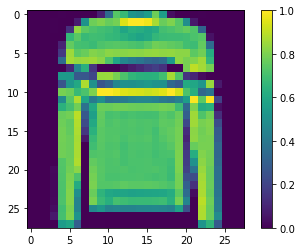

In [14]:
visualize_example(x_train[5])

## 2. Entrenamiento de una red neuronal simple

**Pregunta 2 *(3.5 puntos)***. Utilizando Keras, y preparando los datos de X e y como fuera necesario, define y entrena una red neuronal que sea capaz de clasificar imágenes de Fashion MNIST con las siguientes características:

* Dos hidden layers de tamaños 128 y 64, utilizando unidades **sigmoid**
* Optimizador **sgd**.
* Durante el entrenamiento, la red tiene que mostrar resultados de **loss** y **accuracy** por cada epoch.
* La red debe entrenar durante **20 epochs** y batch size de **64**.
* La última capa debe de ser una capa **softmax**.

Tu red tendría que ser capaz de superar fácilmente 60% de accuracy.

In [14]:
model = Sequential()
model.add(Flatten(input_shape=[28, 28, 1]))
model.add(Dense(128, activation="sigmoid"))
model.add(Dense(64, activation="sigmoid"))
model.add(Dense(10, activation="softmax"))
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer= "sgd",
              metrics =["accuracy"])
history = model.fit(
    x_train,
    y_train, 
    epochs=20,
    batch_size=64,
)

Epoch 1/20
938/938 [==============================] - 1s 440us/step - loss: 2.2863 - accuracy: 0.2649
Epoch 2/20
938/938 [==============================] - 0s 430us/step - loss: 2.0014 - accuracy: 0.5244
Epoch 3/20
938/938 [==============================] - 0s 429us/step - loss: 1.5955 - accuracy: 0.5925
Epoch 4/20
938/938 [==============================] - 0s 427us/step - loss: 1.3113 - accuracy: 0.6254
Epoch 5/20
938/938 [==============================] - 0s 430us/step - loss: 1.1275 - accuracy: 0.6581
Epoch 6/20
938/938 [==============================] - 0s 429us/step - loss: 1.0033 - accuracy: 0.6837
Epoch 7/20
938/938 [==============================] - 0s 432us/step - loss: 0.9202 - accuracy: 0.7059
Epoch 8/20
938/938 [==============================] - 0s 434us/step - loss: 0.8447 - accuracy: 0.7225
Epoch 9/20
938/938 [==============================] - 0s 445us/step - loss: 0.7881 - accuracy: 0.7334
Epoch 10/20
938/938 [==============================] - 0s 453us/step - loss: 0.751

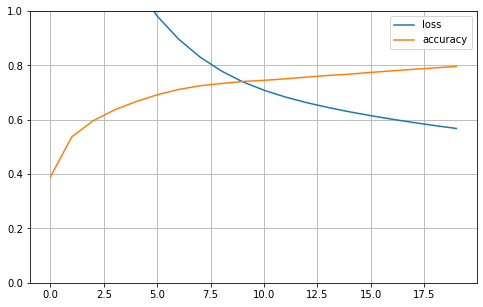

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## 3. Evaluación del modelo en datos de test

Una vez hemos entrenado nuestro modelo, vamos a evaluarlo en los datos de test de Fashion MNIST.

**Pregunta 3.1 *(0.5 puntos)***. Utilizando el modelo recién entrenado, obtener la accuracy resultante en el dataset de test.

In [17]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 0s 292us/step - loss: 0.5847 - accuracy: 0.7868


[0.5846556425094604, 0.7868000268936157]

**Pregunta 3.2 *(0.5 puntos)***. Utilizando el método **predict** de Keras, realizar predicciones para los datos de test. Por cada predicción resultante, ¿qué significan los números que obtenemos al hacer predict? ¿Cómo podemos obtener el valor de la clase resultante? (recordar que estamos utilizando una capa softmax para clasificar).

In [66]:
sample_index = 23
label = y_test[sample_index]

predicted = np.argmax(model.predict(x_test[sample_index].reshape(28, 28, 1)))

print(f"Predicción: {predicted}\nClase real: {label}")
print(f"La red {'' if predicted == label else 'no '}ha acertado la predicción.")

Predicción: 7
Clase real: 9
La red no ha acertado la predicción.


La salida de la red es una vector con la probabilidad 

In [70]:
model.predict(x_test[sample_index].reshape(28, 28, 1)).T

array([[3.6721573e-05],
       [2.1185762e-04],
       [8.3146981e-05],
       [6.1251584e-04],
       [1.1775167e-04],
       [3.0625793e-01],
       [1.5848211e-04],
       [6.4544940e-01],
       [6.0738996e-03],
       [4.0998239e-02]], dtype=float32)

*Tu respuesta aquí*